# Vektorske predstavitve besed

V tem zvezku predstavimo, kako lahko pridobimo vektorske predstavitve (vložitve) besed in kako izrišemo karto izrazov.

Za začetek si preko API-ja pridobimo besedila zadnjih 100 predlogov vladi, ki vsebujejo vsaj 50 znakov (s tem pogojem poskrbimo, da po predprocesiranju ne dobimo praznega seznama pojavnic).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from textsemantics.server_api import ServerAPI

api = ServerAPI()
datasets = api.list_datasets()
metadata = api.get_metadata("predlogi-vladi", sample_size=100, sampling_strategy='latest')

texts = api.get_texts(urls=metadata['text'])
texts = [text for text in texts if len(text) > 50]
print(f'Število predlogov vladi: {len(texts)}')

Število predlogov vladi: 99


Dobili smo 99 dokumentov. Zdaj lahko dokumente predprocesiramo tako, da iz njih odstranimo končnice, jih pretvorimo v seznam pojavnic, odstranimo prazne besede in lematiziramo preostale pojavnice.

In [3]:
import string
import nltk
nltk.download('stopwords', quiet=True)
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from lemmagen.lemmatizer import Lemmatizer
from lemmagen import DICTIONARY_SLOVENE
from IPython.display import display, Markdown

def preprocess(corpus):
    stop_words = set(stopwords.words('slovene'))
    tokenizer = RegexpTokenizer("\w+")
    lemmatizer = Lemmatizer(dictionary=DICTIONARY_SLOVENE)
    
    preprocessed = list()
    for text in corpus:
        text = text.translate(text.maketrans('', '', string.punctuation))
        tokens = tokenizer.tokenize(text.lower())
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words 
                  and len(token) > 2 and not token.isnumeric()]
        preprocessed.append(tokens)
        
    return preprocessed

tokens_list = preprocess(texts)

In [4]:
from collections import Counter

tokens = [t for doc in tokens_list for t in doc]
c = Counter(tokens)
md_string = '### Najpogostejših 10 besed v korpusu\n'

for word, count in c.most_common(10):
    md_string += f"- {word}: {count}\n"

display(Markdown(md_string))

### Najpogostejših 10 besed v korpusu
- imeti: 77
- predlagati: 60
- lahek: 58
- šola: 44
- oseba: 38
- velik: 34
- otrok: 34
- čas: 32
- vlada: 32
- del: 32


Sedaj lahko vsako besedo predstavimo kot vektor. Vektorje bomo dobili z uporabo vložitev, pri čemer bomo besede predstavili z uporabo modela fastText. FastText temelji na nevronskih mrežah in je prednaučen na velikem korpusu dokumentov, pri čemer besede predstavi z nizkodimenzionalnimi vektorji.

In [5]:
from flair.data import Sentence
from flair.embeddings import WordEmbeddings
import numpy as np

def vectorize(tokens):
    words = sorted(set(tokens))
    embedder = WordEmbeddings('sl')
    word_list = []
    X = list()
    for i, word in enumerate(words):
        if len(word) > 50 or not word:
            continue
        sent = Sentence(word)
        embedder.embed(sent)
        for token in sent:
            embedding = token.embedding.numpy()
            if np.count_nonzero(embedding):
                X.append(embedding)
                word_list.append(word)
    return word_list, np.array(X)

word_list, X = vectorize(tokens)
print("Velikost matrike vložitev: ", X.shape)

Velikost matrike vložitev:  (1909, 300)


Sedaj vektorje besed preslikamo v 2D reprezentacijo, da jih bomo lahko izrisali na karti.

In [6]:
from openTSNE.sklearn import TSNE
tsne = TSNE(random_state=0).fit(X)
print(f"Velikost 2D vložitve t-SNE: {tsne.embedding_.shape}")

Velikost 2D vložitve t-SNE: (1909, 2)


Izračunamo še gručenje, s čimer identificiramo podobne si dokumente.

In [7]:
from hdbscan import HDBSCAN

hdbscan = HDBSCAN(min_cluster_size=3, min_samples=1).fit(tsne.embedding_)
labels = hdbscan.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
print(f"Število skupin: {n_clusters}, Število dokumentov, ki niso v skupinah: {n_noise}")

Število skupin: 338, Število dokumentov, ki niso v skupinah: 381


Nato rezultate narišemo na karti. Vidimo, da nastaneta 2 gruči, manjša levo in večja desno.

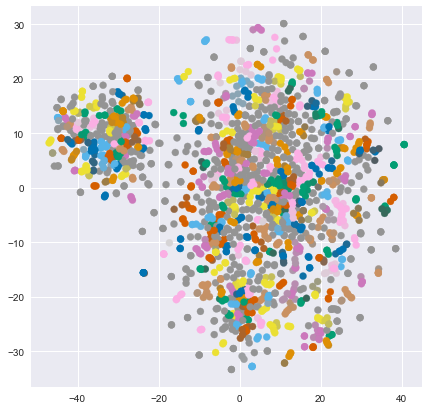

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(7, 7))
plt.style.use('seaborn')
idx = np.where(labels > -1)[0]
palette = sns.color_palette('colorblind', n_clusters)
colors = [sns.desaturate(palette[l] if l >= -1 else (0.5, 0.5, 0.5), p) for 
          l, p in zip(hdbscan.labels_, hdbscan.probabilities_)]
plt.scatter(tsne.embedding_[:, 0], tsne.embedding_[:, 1], c=colors,
            cmap=plt.get_cmap('Spectral'));

Izbrali bomo gručo na levi in izpisali nekaj besed, ki se v njej pojavijo. Vidimo, da je to gruča z glagoli.

In [9]:
cluster = "### Besede iz gruče levo zgoraj\n"
for i in np.array(word_list).reshape(-1, 1)[(tsne.embedding_[:,0] < -20) & (tsne.embedding_[:,1] > -3)][:100:5]:
    cluster += f"- {i[0]}\n"
display(Markdown(cluster))

### Besede iz gruče levo zgoraj
- aktivirati
- dajati
- deti
- dodeliti
- dosegati
- držati
- iskati
- izdajati
- izkazati
- izplačevati
- kazati
- koristiti
- kuriti
- misliti
- nagraditi
- namestiti
- naučiti
- obiskovati
- obvestiti
- oddajati
